This script is for the statistical data analysis for the article "Stable Isotope Resolved Metabolomics Classification of Prostate Cancer Cells using Hyperpolarized NMR Data" by A. Frahm et al. Journal of Magnetic Resonance 2020.

All code is written by A Frahm (afrahm@dtu.dk), except when explicitly stated otherwise.

Versions used:

Python: 3.6.5
Scipy: 1.1.0
sklearn: 0.19.2


Set up data:

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict #Used in RF for ordered dictionary
from scipy import stats #used for box-cox and SEM score for imp.
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, \
StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import svm

#bigger labels on plots
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=10)

#read in data
newdata = pd.ExcelFile("data_ordered.xlsx")
data = newdata.parse('Sheet1')

#get list of cell types from sample name
celltype = np.array([])
for s in data.index:
        cell = s.split("_")[0]
        celltype = np.append(celltype, cell)

data.index = celltype #set sample names only as cell type

#cat list contains agg or non corresponding to celltype
cat = np.array([])
for i in celltype:
    if i in ["DU145", "PC3"]:
        cat = np.append(cat, "AGG")
    else:
        cat = np.append(cat, "NON")

#no values below zero
data = data.where(data>0,0)

#define a color set for plotting
color_set = np.array(["turquoise","b", "r", "orange"])

Code by: Kington, J. D.; Tobin, H. J.,
bibliography code: 2013AGUFM.T31F2580K

Function used for making the STD clouds in the LDA plot

In [25]:
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

Make illustration of identifed metabolites

<Figure size 432x288 with 0 Axes>

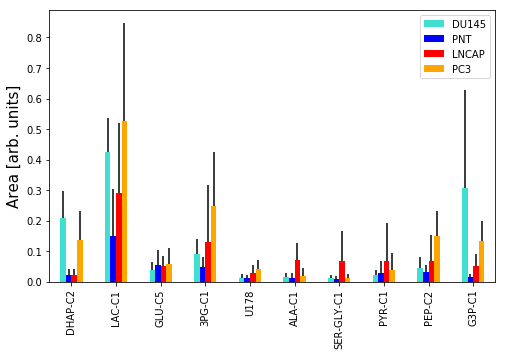

In [26]:
data_means = pd.DataFrame(columns = data.columns)
data_means.loc['DU145'] = data.loc['DU145'].mean().values
data_means.loc['PNT'] = data.loc['PNT'].mean().values
data_means.loc['LNCAP'] = data.loc['LNCAP'].mean().values
data_means.loc['PC3'] = data.loc['PC3'].mean().values


data_std = pd.DataFrame(columns = data.columns)
data_std.loc['DU145'] = data.loc['DU145'].std().values
data_std.loc['PNT'] = data.loc['PNT'].std().values
data_std.loc['LNCAP'] = data.loc['LNCAP'].std().values
data_std.loc['PC3'] = data.loc['PC3'].std().values

#decimate LAC values to make it fit with the rest
data_means['LAC-C1'] = data_means['LAC-C1']/10
data_std['LAC-C1'] = data_std['LAC-C1']/10


#set up STD so only top bar gets plotted
nuller = pd.DataFrame(columns = data.columns, index= data_std.index, 
                      data=np.zeros(np.shape(data_means))).T
err_pos = data_std.T
err = []

for col in err_pos:
    err.append([nuller[col].values, err_pos[col].values])

#make plot
f = plt.figure()
data_means.T.plot.bar(yerr = err, figsize=(8, 5), color = color_set)
plt.legend(loc='upper right')
plt.ylabel('Area [arb. units]')
plt.show()

ANOVA test for significance of metabolites between cell lines

In [27]:
#bonferoni corrected significance
b5 = 0.05/len(data.columns)
b1 = 0.01/len(data.columns)

df_anova = pd.DataFrame(columns= ["F value", "P value", 
                                  "Bonferoni corrected significance"], 
                        index = data.columns)

for met in data.columns:
    f, p = stats.f_oneway(data[met].loc['PNT'],data[met].loc['LNCAP'], 
                          data[met].loc['DU145'], 
                          data[met].loc['PC3'])
    
    if p < b1:
        df_anova.loc[met] = [f, p, "Significant > 99%"]
        print("%s is below 1%% significant" % (met))
    
    elif p < b5 :
        df_anova.loc[met] = [f, p, "Significant > 95%"]
        print("%s is below 5%% significant" % (met))
        
    else:
        df_anova.loc[met] = [f, p, "Not significant"]
        print ("%s is not significant" % (met))
    
df_anova.to_excel("anova.xlsx")

DHAP-C2 is below 1% significant
LAC-C1 is not significant
GLU-C5 is not significant
3PG-C1 is not significant
U178 is not significant
ALA-C1 is below 5% significant
SER-GLY-C1 is not significant
PYR-C1 is not significant
PEP-C2 is below 5% significant
G3P-C1 is not significant


In [28]:
lines = data.index.unique()
for met in data.columns:
    for n in np.arange(3):
        m = n+1 
        while m < 4:
            t, p = stats.ttest_ind(data[met].loc[lines[n]], 
                                   data[met].loc[lines[m]], equal_var= False)
            if p < 0.01/60:
                print(met, lines[n], lines[m], p, "99% SIGNIFICANT!!")
            elif p < 0.05/60:
                print(met, lines[n], lines[m], p, "95% SIGNIFICANT!!")
            else: 
                print(met, lines[n], lines[m], p)
            m = m +1

DHAP-C2 PNT LNCAP 0.8941902748637687
DHAP-C2 PNT DU145 0.0004606434758217633 95% SIGNIFICANT!!
DHAP-C2 PNT PC3 0.010216479217743338
DHAP-C2 LNCAP DU145 0.0004348123834141082 95% SIGNIFICANT!!
DHAP-C2 LNCAP PC3 0.009686486854772159
DHAP-C2 DU145 PC3 0.14427300409572197
LAC-C1 PNT LNCAP 0.17020499774222966
LAC-C1 PNT DU145 0.0012578645066920616
LAC-C1 PNT PC3 0.012866424774430679
LAC-C1 LNCAP DU145 0.16883646739676883
LAC-C1 LNCAP PC3 0.11392914000575834
LAC-C1 DU145 PC3 0.41570383065222594
GLU-C5 PNT LNCAP 0.9249975342533919
GLU-C5 PNT DU145 0.4663568134404792
GLU-C5 PNT PC3 0.9160866163729089
GLU-C5 LNCAP DU145 0.369615019575647
GLU-C5 LNCAP PC3 0.8275355104688435
GLU-C5 DU145 PC3 0.4035049391151373
3PG-C1 PNT LNCAP 0.25367459789922825
3PG-C1 PNT DU145 0.07273554155109954
3PG-C1 PNT PC3 0.01586884496233845
3PG-C1 LNCAP DU145 0.5639212229507107
3PG-C1 LNCAP PC3 0.22075452134592063
3PG-C1 DU145 PC3 0.042475873739478406
U178 PNT LNCAP 0.154289256196999
U178 PNT DU145 0.825181883429954
U17

Make random forest classification and importance ranking:

In [29]:
def makerf_1000(data, cat = False):
    
    if cat == 0:
        cat = data.index
    
    #define Random Forest classifier and fit to all data
    rf = RF(n_estimators= 500, oob_score= True)
    rf.fit(data,cat)
    
    print("Out-of-bag score (%):", rf.oob_score_*100)
    
    scores = defaultdict(list) #empty library for tracking scores

    #define train-test splits, stratified to ensure all cell lines are in test
    splits = StratifiedShuffleSplit(1000, 0.7)

    #run test 
    for train_idx, test_idx in splits.split(data, cat):
        X_train, X_test = data.values[train_idx], data.values[test_idx]
        Y_train, Y_test = cat[train_idx], cat[test_idx]
    
        r = rf.fit(X_train, Y_train)
    
        acc = sum(rf.predict(X_test) == Y_test)/len(Y_test)
    
        #for each feature get difference in accuracy when test classes are shuffled
        for i in range(len(data.columns)):
            X_t = X_test.copy()
            np.random.shuffle(X_t[:, i])
            shuff_acc = sum(rf.predict(X_t) == Y_test)/len(Y_test)
            scores[data.columns[i]].append((acc-shuff_acc)/acc)

        
    imp = pd.DataFrame(columns= ['Mean', 'std err.', 'color'])

    #color code positive-negative
    for feat in scores: 
        m = np.mean(scores[feat])
        c = 'g'
        if m > 0:
            c = 'r'
        imp.loc[feat] = [m, stats.sem(scores[feat]), c] 
        #stats.sem = standard error on the mean

    imp=imp.sort_values('Mean', ascending = False)
    
    imp.plot.bar(y = 'Mean', yerr = 'std err.', color = imp.color, legend = False)
    plt.ylabel('Relative importance ')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Out-of-bag score (%): 93.75


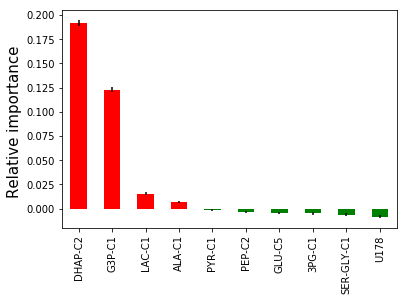

In [30]:
makerf_1000(data,cat)

Box-cox transformation of data

In [31]:
def bc_trans(data):
    
    """
    Transformations of all columns in data except the reference, 
    which is set to all zeros.
    data: DataFrame with integral values. No value can be < 0.
    databc: BoxCox transformed and standardized DataFrame.
    """
    
    databc = pd.DataFrame()
    
    for column in data:
        #sort reference out
        if data.std()[column]!= 0:
            #add small number for > 0 and transform column
            bc= stats.boxcox(data[column]+0.0000000001)[0]
            databc[column] = bc
        else:
            #reference set as zeros
            databc[column] = np.zeros(len(data[column]))
    
    #standardize by substracting mean and dividing with std for each column
    databc = databc.sub(databc.mean()).div(databc.std())
    
    databc = databc.fillna(0)
    databc.index = data.index
    
    return databc

In [32]:
bc_data = bc_trans(data)

PC-DFA on transformed data

In [33]:
def makepcdfa(data):
    
    #make PCA
    pca = PCA(.95)
    pca.fit(data)
    data_pc = pca.transform(data)
      
    #Number samples
    cell_order = {'PNT': 0, 'LNCAP': 1, 'PC3': 2, 'DU145': 3}
    labels_data = np.array([cell_order[i] for i in list(data.index.values)])
    label_set = ['PNT', 'LNCAP', 'PC3', 'DU145']
    
    colors = {}
    for i in range(len(label_set)):
        colors[label_set[i]] = color_set[i]
        
    
    #plot PCA
    for label in range(len(label_set)):
        c = colors[label_set[label]]
        x = data_pc[:,0][labels_data == label]
                
        y=data_pc[:,1][labels_data == label]
        
        plt.scatter(x,y, color = c, label = label_set[label])
             
    plt.xlabel('1. Principal Component')
    plt.ylabel('2. Principal Component')
    #plt.title('PCA transformation')
    plt.legend(loc = 2)
    plt.show()
    
    types = len(label_set) #how many different types to differentiate
    
    #set up LDA
    lda_d = LDA(n_components=(types-1))
    lda_d.priors = np.ones(types)/types
    data_lda_d = lda_d.fit_transform(data_pc, labels_data)
    
    #Cross validated training
    loo = LeaveOneOut()
    predicted_loo = cross_val_predict(lda_d, data_pc, labels_data, cv= loo)
    loo_scores = cross_val_score(lda_d, data_pc, labels_data, cv= loo)
    acc_loo = loo_scores.mean()*100
       
    #plot LDA
    for label in range(len(label_set)): #loops over cell lines
        
        c = colors[label_set[label]]
        
        x = data_lda_d[:,0][labels_data == label]
        
        y=data_lda_d[:,1][labels_data == label]
        
        plt.scatter(x,y, color = c, label = label_set[label])
        
        #plots 2.STD cloud
        plot_point_cov(np.stack([x, y],1), nstd=2, alpha=0.2, color=c)

        
    plt.xlabel('1. Discriminant Function')
    plt.ylabel('2. Discriminant Function')
    #plt.title('PC-DFA seperation')
    plt.legend(loc = 2)
    plt.show()
    
    errors = pd.DataFrame([acc_loo], columns = ["Leave-one-out"], 
                          index = ["error rate"])
    
    #make confusion matrices
    
    lab = np.array([label_set[s] for s in labels_data])    
    pre = np.array([label_set[s] for s in predicted_loo])
    con_loo = pd.crosstab(lab, pre, rownames= ["Actual"], 
                          colnames= ["predicted loo"])
    
        
    print("Variance in 1. PCA component: %.2f%%" 
          %(pca.explained_variance_ratio_[0]*100))
    print("Variance in 2. PCA component: %.2f%%" 
          %(pca.explained_variance_ratio_[1]*100))
    print("Total variance in PCA %.2f%%" %(sum(pca.explained_variance_ratio_)*100))
    print("Number of PCA components used:", pca.n_components_)

    print(errors)
    print(con_loo)

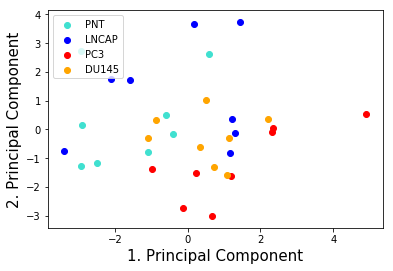

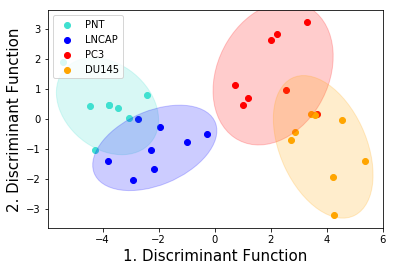

Variance in 1. PCA component: 34.47%
Variance in 2. PCA component: 26.65%
Total variance in PCA 95.68%
Number of PCA components used: 7
            Leave-one-out
error rate         78.125
predicted loo  DU145  LNCAP  PC3  PNT
Actual                               
DU145              7      0    1    0
LNCAP              0      5    0    3
PC3                1      0    7    0
PNT                0      2    0    6


In [34]:
makepcdfa(bc_data)
#Results are the same as presented in article but table is written in different order

SVM analysis

In [35]:
#standardize data
data_s = pd.DataFrame(scale(data),index = data.index, columns= data.columns)

svc = svm.SVC(probability=True, kernel='linear')

validation_scores = np.array([])
best_cs = np.array([])
successes = np.array([])


#different feature sets to be tested
full = data.columns
best4 = ['DHAP-C2', 'G3P-C1', 'LAC-C1','ALA-C1']
best3 = ['DHAP-C2', 'G3P-C1', 'LAC-C1']
other_3_1 = ['DHAP-C2', 'G3P-C1', 'ALA-C1']
other_3_2 = ['DHAP-C2', 'LAC-C1','ALA-C1']
other_3_3 = ['G3P-C1', 'LAC-C1','ALA-C1']
dhap_lac = ['DHAP-C2','LAC-C1']
dhap_gap = ['DHAP-C2', 'G3P-C1']
dhap_ala = ['DHAP-C2', 'ALA-C1']
lac_gap = ['G3P-C1', 'LAC-C1']
lac = ['LAC-C1']
dhap = ['DHAP-C2']
ga3p = ['G3P-C1']
ala = ['ALA-C1']
lac_ala = ['LAC-C1', 'ALA-C1']
ga3p_ala = ['G3P-C1', 'ALA-C1']
pep = ['G3P-C1', 'LAC-C1','PEP-C2']

feature_sets = np.array([full, best4, best3, dhap_lac, dhap_gap, lac_gap, lac, dhap, 
                         ga3p, ala, dhap_ala, lac_ala, ga3p_ala, other_3_1, 
                         other_3_2, other_3_3, pep])

for fs in feature_sets:
    x = data_s[fs]
       
    clf = svm.SVC(probability=True, kernel = 'linear', C= 1)
    clf.fit(x, cat)
    
    predicted_loo = cross_val_predict(clf, x, cat, cv= LeaveOneOut())
    successes = np.append(successes, sum(predicted_loo == cat)/len(cat))

svm_resulst = pd.DataFrame(index = np.append('All', feature_sets[1:]))
svm_resulst["Validation scores"] = successes


print(svm_resulst)

                                   Validation scores
All                                          0.93750
[DHAP-C2, G3P-C1, LAC-C1, ALA-C1]            0.96875
[DHAP-C2, G3P-C1, LAC-C1]                    0.93750
[DHAP-C2, LAC-C1]                            0.90625
[DHAP-C2, G3P-C1]                            0.90625
[G3P-C1, LAC-C1]                             0.81250
[LAC-C1]                                     0.75000
[DHAP-C2]                                    0.90625
[G3P-C1]                                     0.84375
[ALA-C1]                                     0.62500
[DHAP-C2, ALA-C1]                            0.90625
[LAC-C1, ALA-C1]                             0.81250
[G3P-C1, ALA-C1]                             0.93750
[DHAP-C2, G3P-C1, ALA-C1]                    0.93750
[DHAP-C2, LAC-C1, ALA-C1]                    0.93750
[G3P-C1, LAC-C1, ALA-C1]                     0.96875
[G3P-C1, LAC-C1, PEP-C2]                     0.78125
